In [26]:

import pandas as pd
import numpy as np
import argparse
from argparse import ArgumentParser 
import wandb
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import json
import os
from os.path import exists, join
from tqdm import tqdm
from selfpeptide.utils.data_utils import load_immunogenicity_dataframes_calibration, load_binding_affinity_dataframes
from selfpeptide.utils.data_utils import SequencesInteractionDataset_returnHLA, SequencesInteractionDataset
from selfpeptide.utils.training_utils import get_class_weights, sigmoid
from selfpeptide.utils.training_utils import lr_schedule, warmup_constant_lr_schedule, eval_classification_metrics
from selfpeptide.model.immunogenicity_classifier import JointPeptidesNetwork_Classifier
from selfpeptide.utils.constants import *



import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
folder = "../outputs/check_pseudolabels/logical-sweep-6"
os.listdir(folder)


['train_set.csv',
 'architecture.txt',
 'calib_set.csv',
 'generated_pseudolabels_set.csv',
 'test_set.csv',
 'val_set.csv',
 'checkpoints',
 'config.json']

In [3]:
with open(join(folder, "config.json"), "r") as f:
    config = json.load(f)
config

{'PMA_ln': True,
 'PMA_num_heads': 4,
 'accumulate_batches': 64,
 'batch_size': 16,
 'binding_affinity_df': '/home/gvisona/SelfPeptides/processed_data/Binding_Affinity/DHLAP_binding_affinity_data.csv',
 'binding_model_checkpoint': '/home/gvisona/SelfPeptides/trained_models/binding_model/checkpoints/001_checkpoint.pt',
 'binding_model_config': '/home/gvisona/SelfPeptides/trained_models/binding_model/config.json',
 'conformal_alpha': 0.2,
 'cool_down': 0.8,
 'dhlap_df': '/home/gvisona/Immunology/processed_data/DHLAP_immunogenicity_data.csv',
 'dropout_p': 0.05,
 'early_stopping': True,
 'embedding_dim': 512,
 'experiment_group': 'IEDB_Class_JointNetwork',
 'experiment_name': 'GenPL_JointPeptides_MCC',
 'hla_repr': 'Allele Pseudo-sequence',
 'immunogenicity_df': '/home/gvisona/Immunology/processed_data/IEDB/Processed_TCell_IEDB_Beta_noPrior.csv',
 'lr': 2.062171531477938e-06,
 'max_updates': 10000,
 'mean_threshold': 'none',
 'min_frac': 0.1,
 'min_subjects_tested': 1,
 'mlp_hidden_dim': 

In [9]:
config["binding_affinity_df"] = '/home/gvisona/Projects/SelfPeptides/processed_data/Binding_Affinity/DHLAP_binding_affinity_data.csv'
config["binding_model_checkpoint"] = '/home/gvisona/Projects/SelfPeptides/trained_models/binding_model/checkpoints/001_checkpoint.pt'
config["binding_model_config"] = '/home/gvisona/Projects/SelfPeptides/trained_models/binding_model/config.json'
config["dhlap_df"] = '/home/gvisona/Projects/SelfPeptides/processed_data/Immunogenicity/DHLAP_immunogenicity_data.csv'

config["immunogenicity_df"] = '/home/gvisona/Projects/SelfPeptides/processed_data/Immunogenicity/Processed_TCell_IEDB_Beta_noPrior.csv'
config["pretrained_aa_embeddings"] = '/home/gvisona/Projects/SelfPeptides/processed_data/aa_embeddings/learned_BA_AA_embeddings.npy'
config["project_folder"] = '/home/gvisona/Projects/SelfPeptides'
config["pseudo_seq_file"] = '/home/gvisona/Projects/SelfPeptides/data/NetMHCpan_pseudoseq/MHC_pseudo.dat'
config["sns_model_checkpoint"] = '/home/gvisona/Projects/SelfPeptides/trained_models/sns_model/checkpoints/001_checkpoint.pt'
config["sns_model_config"] = '/home/gvisona/Projects/SelfPeptides/trained_models/sns_model/config.json'

device="cpu"



In [14]:
train_df, val_df, calib_df, test_df, dhlap_imm_df = load_immunogenicity_dataframes_calibration(config)

ba_df = load_binding_affinity_dataframes(config, split_data=False)
# ba_df = ba_df[ba_df["Label"]==1]
ba_df["Peptide Length"] = ba_df["Peptide"].str.len()
ba_df = ba_df[(ba_df["Peptide Length"]>=MIN_PEPTIDE_LEN)&(ba_df["Peptide Length"]<=MAX_PEPTIDE_LEN)]

iedb_samples = set(tuple(x) for x in train_df[["Peptide", "HLA"]].values).union(
    set(tuple(x) for x in val_df[["Peptide", "HLA"]].values)).union(
    set(tuple(x) for x in calib_df[["Peptide", "HLA"]].values)).union(
    set(tuple(x) for x in test_df[["Peptide", "HLA"]].values))
ba_samples = set(tuple(x) for x in ba_df[["Peptide", "HLA"]].values)
ba_df = ba_df[ba_df[["Peptide", "HLA"]].apply(tuple, 1).isin(ba_samples.difference(iedb_samples))]

IEDB N. training samples: 20358
IEDB N. val samples: 2254
IEDB N. test samples: 4508


In [25]:
ba_df

,HLA,Peptide,Method,Measurement,Type,Affinity(nM),Label,Allele Pseudo-sequence,Stratification_index,Peptide Length
0,HLA-B08:01,HMMVIFRLM,purified MHC/competitive/fluorescence,half maximal inhibitory concentration (IC50),Negative,3439140.0,0,YDSEYRNIFTNTDESNLYLSYNYYTWAVDAYTWY,HLA-B08:01_0,9
1,HLA-B08:01,NFLIKFLLI,purified MHC/competitive/fluorescence,half maximal inhibitory concentration (IC50),Negative,1606610.0,0,YDSEYRNIFTNTDESNLYLSYNYYTWAVDAYTWY,HLA-B08:01_0,9
2,HLA-A24:02,SSKYYIKNI,purified MHC/competitive/fluorescence,half maximal inhibitory concentration (IC50),Negative,1449300.0,0,YSAMYEEKVAHTDENIAYLMFHYYTWAVQAYTGY,HLA-A24:02_0,9
3,HLA-A11:01,KLYKNKSKQ,purified MHC/competitive/fluorescence,half maximal inhibitory concentration (IC50),Negative,1360000.0,0,YYAMYQENVAQTDVDTLYIIYRDYTWAAQAYRWY,HLA-A11:01_0,9
4,HLA-A02:01,AMEKSSKYY,purified MHC/competitive/fluorescence,half maximal inhibitory concentration (IC50),Negative,1166430.0,0,YFAMYGEKVAHTHVDTLYVRYHYYTWAVLAYTWY,HLA-A02:01_0,9
...,...,...,...,...,...,...,...,...,...,...
327140,HLA-A11:01,SVQMTLSK,purified MHC,qualitative binding,Positive,0.0,1,YYAMYQENVAQTDVDTLYIIYRDYTWAAQAYRWY,HLA-A11:01_1,8
327141,HLA-A02:09,TLGIVCPI,cellular MHC/direct/fluorescence,qualitative binding,Positive,0.0,1,YFAMYGEKVAHTHVDTLYVRYHYYTWAVLAYTWY,HLA-A02:09_1,8
327142,HLA-A11:01,TTSPIPLK,purified MHC,qualitative binding,Positive,0.0,1,YYAMYQENVAQTDVDTLYIIYRDYTWAAQAYRWY,HLA-A11:01_1,8
327143,HLA-A03:01,TVTTITVY,cellular MHC/direct/fluorescence,qualitative binding,Positive,0.0,1,YFAMYQENVAQTDVDTLYIIYRDYTWAELAYTWY,HLA-A03:01_1,8


In [10]:
model = JointPeptidesNetwork_Classifier(config, config["binding_model_config"], config["sns_model_config"], 
                             binding_checkpoint=config["binding_model_checkpoint"], 
                             sns_checkpoint=config["sns_model_checkpoint"],
                             device=device)

In [13]:
model.load_state_dict(torch.load(join(folder, "checkpoints", "001_checkpoint.pt"), map_location=torch.device('cpu')))
model.immunogenicity_model.eval()

ImmunogenicityBinaryClassifier(
  (immunogenicity_aa_embedder): PeptideEmbedder(
    (tokenizer): AA_Tokenizer()
    (aa_embs): Embedding(23, 512)
    (transformer_encoder): TransformerEncoder(
      (pos_encoding): PositionalEncoding(
        (dropout): Dropout(p=0.05, inplace=False)
      )
      (dropout): Dropout(p=0.05, inplace=False)
      (encoder_layers): ModuleList(
        (0-1): 2 x TEncoderLayer(
          (multihead_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (dropout1): Dropout(p=0.05, inplace=False)
          (res_norm1): ResNorm(
            (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          )
          (feed_forward): Sequential(
            (0): Linear(in_features=512, out_features=512, bias=True)
            (1): ReLU()
            (2): Linear(in_features=512, out_features=512, bias=True)
          )
          (dropout2): Dropout(p=0.05

# Check non-binders 

In [16]:
ba_non_binders = ba_df[ba_df["Label"]==0].reset_index(drop=True)
ba_non_binders

,HLA,Peptide,Method,Measurement,Type,Affinity(nM),Label,Allele Pseudo-sequence,Stratification_index,Peptide Length
0,HLA-B08:01,HMMVIFRLM,purified MHC/competitive/fluorescence,half maximal inhibitory concentration (IC50),Negative,3439140.0,0,YDSEYRNIFTNTDESNLYLSYNYYTWAVDAYTWY,HLA-B08:01_0,9
1,HLA-B08:01,NFLIKFLLI,purified MHC/competitive/fluorescence,half maximal inhibitory concentration (IC50),Negative,1606610.0,0,YDSEYRNIFTNTDESNLYLSYNYYTWAVDAYTWY,HLA-B08:01_0,9
2,HLA-A24:02,SSKYYIKNI,purified MHC/competitive/fluorescence,half maximal inhibitory concentration (IC50),Negative,1449300.0,0,YSAMYEEKVAHTDENIAYLMFHYYTWAVQAYTGY,HLA-A24:02_0,9
3,HLA-A11:01,KLYKNKSKQ,purified MHC/competitive/fluorescence,half maximal inhibitory concentration (IC50),Negative,1360000.0,0,YYAMYQENVAQTDVDTLYIIYRDYTWAAQAYRWY,HLA-A11:01_0,9
4,HLA-A02:01,AMEKSSKYY,purified MHC/competitive/fluorescence,half maximal inhibitory concentration (IC50),Negative,1166430.0,0,YFAMYGEKVAHTHVDTLYVRYHYYTWAVLAYTWY,HLA-A02:01_0,9
...,...,...,...,...,...,...,...,...,...,...
69096,HLA-B18:01,YDFAFRDL,purified MHC/direct/fluorescence,qualitative binding,Negative,0.0,0,YHSTYRNISTNTYESNLYLRYDSYTWAVLAYTWH,HLA-B18:01_0,8
69097,HLA-B27:05,YDFAFRDL,purified MHC/direct/fluorescence,qualitative binding,Negative,0.0,0,YHTEYREICAKTDEDTLYLNYHDYTWAVLAYEWY,HLA-B27:05_0,8
69098,HLA-B35:01,YDFAFRDL,purified MHC/direct/fluorescence,qualitative binding,Negative,0.0,0,YYATYRNIFTNTYESNLYIRYDSYTWAVLAYLWY,HLA-B35:01_0,8
69099,HLA-B51:01,YDFAFRDL,purified MHC/direct/fluorescence,qualitative binding,Negative,0.0,0,YYATYRNIFTNTYENIAYWTYNYYTWAELAYLWH,HLA-B51:01_0,8


In [17]:
ba_non_binders_dset = SequencesInteractionDataset_returnHLA(ba_non_binders, hla_repr=config["hla_repr"], target_label="Label")
ba_non_binders_loader = DataLoader(ba_non_binders_dset, batch_size=config['batch_size'], drop_last=False, shuffle=False)

In [19]:
non_binders_predictions = []
for ix, pl_batch in tqdm(enumerate(ba_non_binders_loader)):
    peptides, hla_alleles, hla_pseudoseqs = pl_batch[:3]
    predictions = model(peptides, hla_pseudoseqs).view(-1)

    predictions = predictions.detach().cpu().tolist()
    non_binders_predictions.extend(predictions)
    
np.mean(non_binders_predictions)

4319it [05:01, 14.32it/s]


-0.03706465757101491

In [20]:
predictions

[7.119601249694824,
 2.6604766845703125,
 1.80814790725708,
 2.158299207687378,
 -1.9273244142532349,
 -3.0360355377197266,
 0.0513630285859108,
 -4.35223388671875,
 -0.5761505365371704,
 0.07967815548181534,
 0.9847123026847839,
 0.026322016492486,
 -1.6337411403656006]

In [22]:
np.mean(sigmoid(np.array(non_binders_predictions)))

0.5130297162587478

In [24]:
xx = sigmoid(np.array(non_binders_predictions))

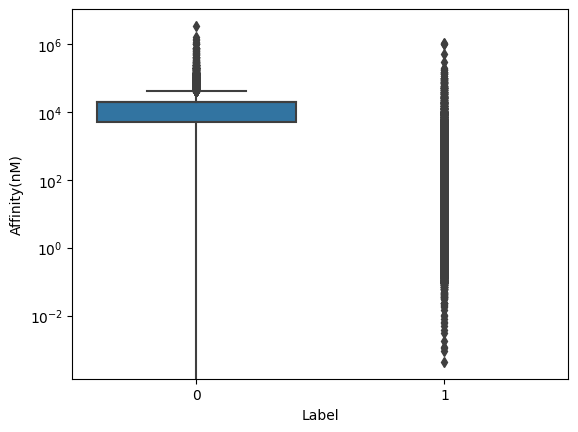

In [28]:
g = sns.boxplot(ba_df, y="Affinity(nM)", x="Label")
g.set_yscale("log")

In [29]:
ba_df["Measurement"].value_counts()

ligand presentation                             187060
dissociation constant KD (~IC50)                 46712
dissociation constant KD (~EC50)                 29753
qualitative binding                              20610
dissociation constant KD                         18425
half maximal inhibitory concentration (IC50)      5754
half life                                         2983
half maximal effective concentration (EC50)        280
3D structure                                       152
50% dissociation temperature                        60
Name: Measurement, dtype: int64